### libs

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

### Nets

In [2]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image


class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

### Helper

In [32]:
def denoising(mask, kernel_size):
    blurred_img = cv2.medianBlur(mask, 5)

    kernel = np.ones((kernel_size,kernel_size))
    erosion = cv2.erode(blurred_img, kernel, iterations=1)
    output = cv2.dilate(erosion, kernel, iterations=1)

    return output

In [4]:
def back_mask(corrupted_images, generated_images, threshold=0.9):
    mask_ = corrupted_images/generated_images
    mask = 1-mask_
    mask [mask<threshold] = 0
    #a = (corrupted_images - generated_images).abs()
    mask = 1-mask
    return mask

In [5]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
def ploter(corrupted_images, generated_images, original_images):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,3,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(corrupted_images)
    plt.tight_layout()
    plt.title("corrupted")

    plt.subplot(1,3,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(generated_images)
    plt.tight_layout()
    plt.title("generated")

    plt.subplot(1,3,3)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(original_images)
    plt.tight_layout()
    plt.title("original")

    plt.show()

In [7]:
def context_loss(corrupted_images, generated_images, masks, weighted=True):
    return torch.sum(((corrupted_images-generated_images)**2)*masks)

In [8]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

In [9]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

### Dataset

In [10]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [11]:
def mask_maker(image_size):

    mask = np.ones(image_size,dtype=np.float32)
    x = np.random.randint(image_size[0]//6,5*image_size[0]//6)
    y = np.random.randint(image_size[1]//6,5*image_size[1]//6)
    h = np.random.randint(image_size[0]//4,image_size[0]//2)
    w = np.random.randint(image_size[1]//4,image_size[1]//2)
    mask[max(0,x-h//2):min(image_size[0],x+h//2),max(0,y-w//2):min(image_size[1],y+w//2)] = 0

    return mask

### Hyperparameters

In [271]:
root_best_model = "epoch220_disloss24.18_genloss52.93.pt"

window_size = 25 #??
batch_size = 1
num_sub = 1

img_size = 28
latent_dim = 100
channels = 1

optim_steps = 1000 # ???
sample_interval = 100

prior_weight = 0.003 # ???

### Phase1

In [279]:
root_ds = "./MNIST"

In [280]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,) , (0.5,))
])

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [281]:
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))
test_loader=DataLoader(test_data, batch_size= 1, sampler=test_sampler)

In [282]:
for original_images, _ in test_loader:
    original_images=original_images
    break
original_images.shape

torch.Size([1, 1, 28, 28])

In [283]:
# Loading trained GAN model
saved_gan = torch.load(root_best_model)

generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=channels).cuda()
discriminator = Discriminator(channels=channels, img_size=img_size).cuda()

generator.load_state_dict(saved_gan["state_dict_G"])
discriminator.load_state_dict(saved_gan["state_dict_D"])

<All keys matched successfully>

In [284]:
z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())
optimizer_inpaint = optim.Adam([z_optimum], lr=0.1)

### Corrupted Image

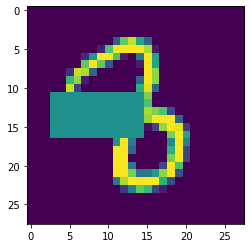

In [286]:
# mask = self.mask.reshape((1,)+self.mask.shape)
#target_image[0][1-self.mask > 0.5] = np.max(target_image)
mask = mask_maker((28,28))
corrupted_images = original_images[0,0,:,:] * mask
corrupted_images = corrupted_images.unsqueeze(0).unsqueeze(0)
plt.imshow(corrupted_images[0][0])

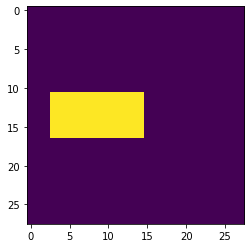

In [411]:
plt.imshow(1-mask)

In [288]:
# Reach to Best Mask
# While( minimum(generated_images - corrupted_images) )

corrupted_images = corrupted_images.cuda()

for epoch in range(20):
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = torch.sum(((corrupted_images-generated_images)**2))
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + 1*prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()

In [300]:
mask_hat.shape

torch.Size([1, 1, 28, 28])

In [317]:
mask_hat.shape

torch.Size([1, 1, 28, 28])

In [393]:
mask_hat.detach().cpu().numpy()[0][0]

(28, 28)

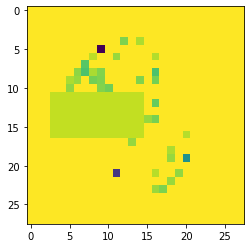

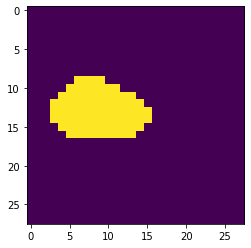

In [406]:
mask_hat = back_mask(corrupted_images, generated_images, threshold=0.9)
mask_hat_clean = denoising(mask_hat.detach().cpu().numpy()[0][0], kernel_size=3)

plt.figure()
plt.imshow(mask_hat.detach().cpu()[0][0])
plt.figure()
plt.imshow(1-mask_hat_clean)

In [487]:
class MaskMapping(nn.Module):
    def __init__(self):
        super(MaskMapping, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(
            x.flatten(start_dim=1)
        ).view(1,1, 28,28)

In [488]:
criterion = nn.MSELoss()
m = MaskMapping()
optim = torch.optim.Adam(m.parameters())

epoch : 0


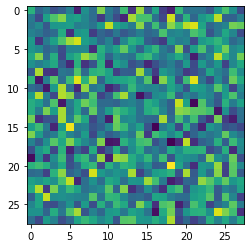

epoch : 20


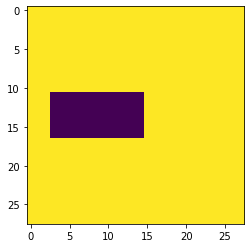

epoch : 40


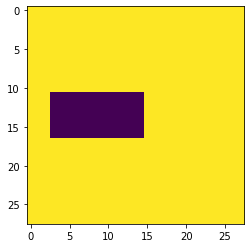

epoch : 60


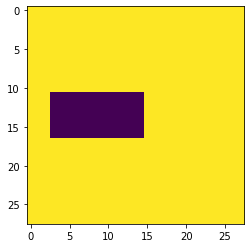

epoch : 80


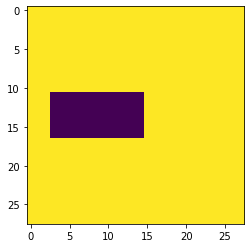

In [489]:
for epoch in range(100):
    optim.zero_grad()
    #x = torch.tensor(mask_hat_clean).unsqueeze(0).unsqueeze(0)
    x = torch.tensor(mask_hat.detach().cpu().numpy()[0][0]).unsqueeze(0).unsqueeze(0)
    y = torch.tensor(mask).unsqueeze(0).unsqueeze(0)
    x_hat = m(x)
    loss = criterion(x_hat,y)
    loss.backward(retain_graph=True)
    optim.step()

    if epoch % 20 == 0:
        print(f"epoch : {epoch}")
        plt.figure()
        plt.imshow(x_hat[0][0].detach().cpu())
        plt.show()

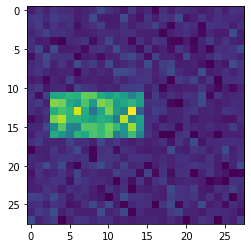

In [462]:
plt.imshow(x_hat[0][0].detach().cpu())

### phase 2

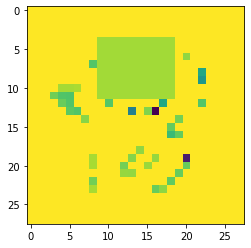

In [238]:
plt.imshow(mask.detach().cpu()[0][0])

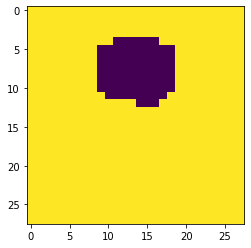

In [239]:
mask_denoised = denoising(mask.detach().cpu().numpy()[0][0], kernel_size=3)
plt.imshow(mask_denoised)

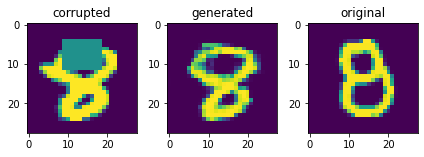

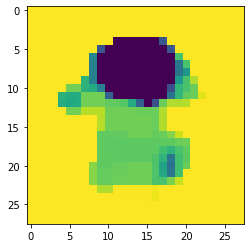

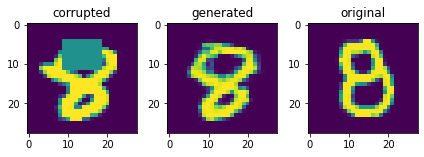

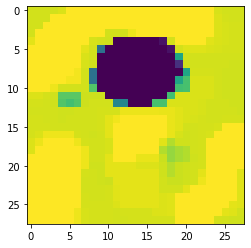

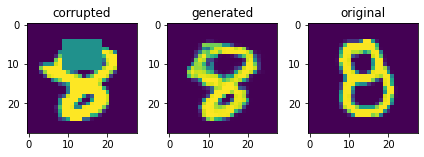

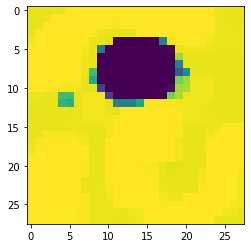

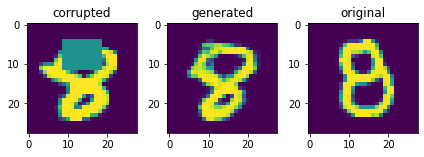

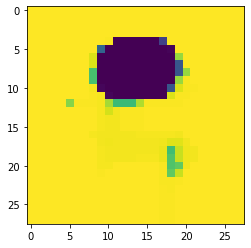

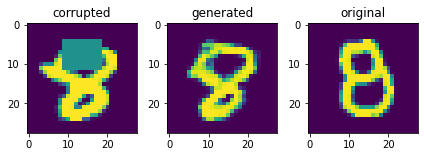

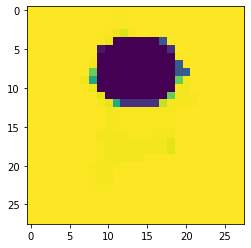

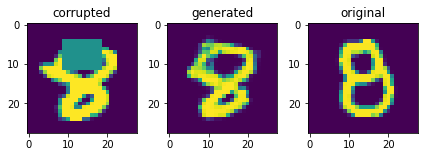

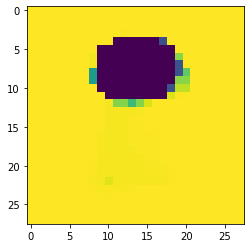

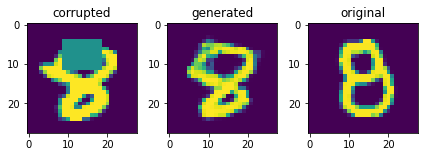

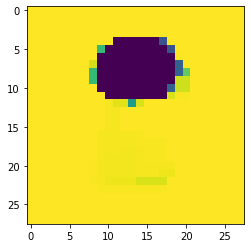

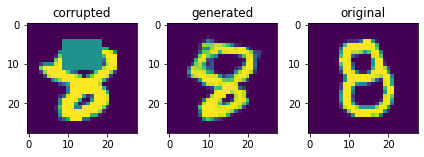

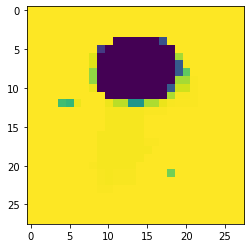

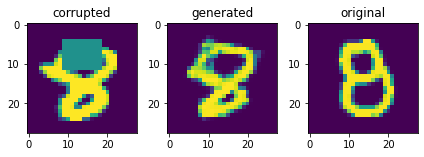

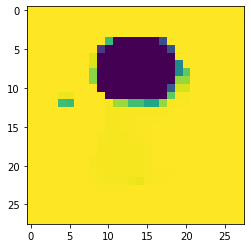

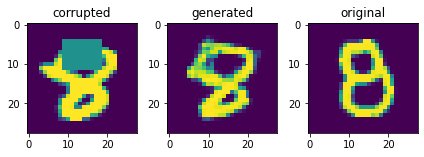

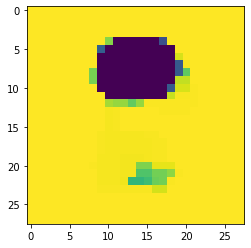

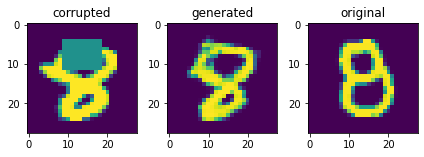

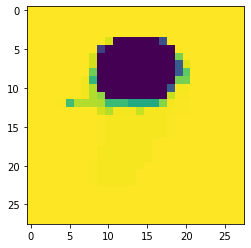

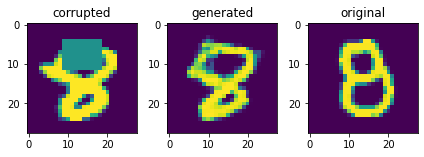

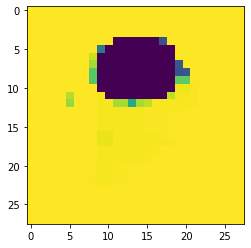

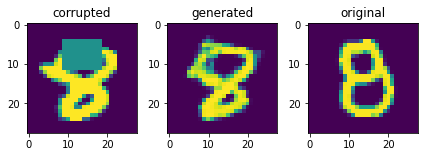

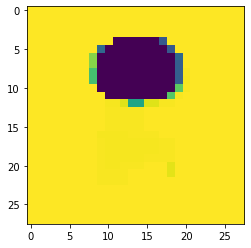

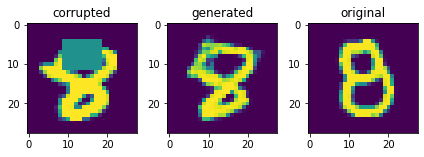

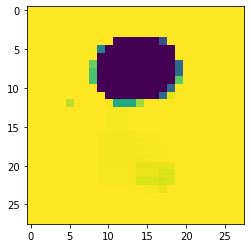

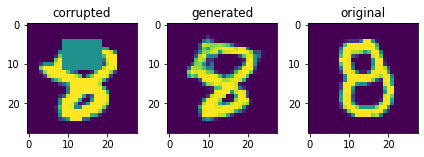

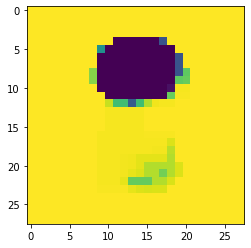

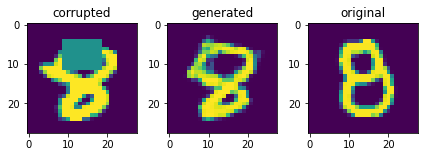

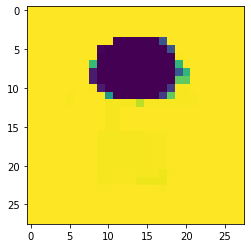

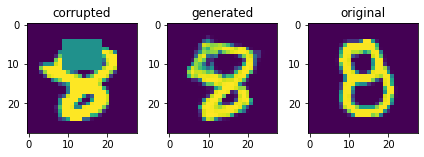

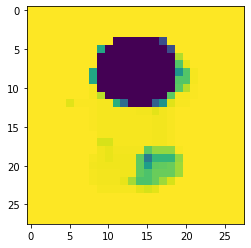

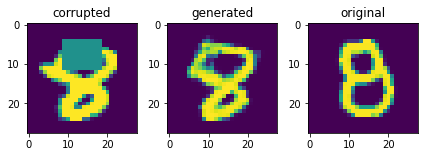

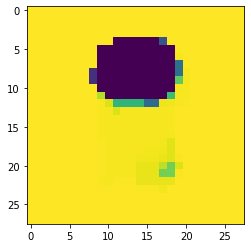

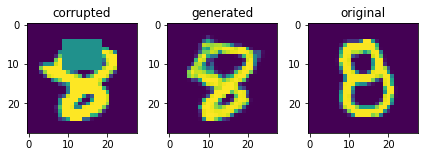

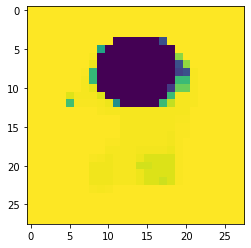

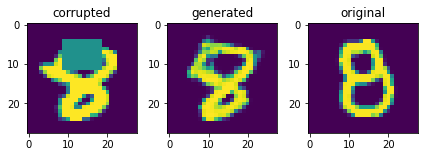

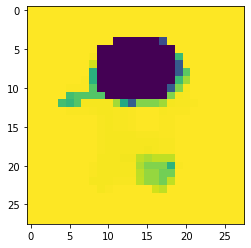

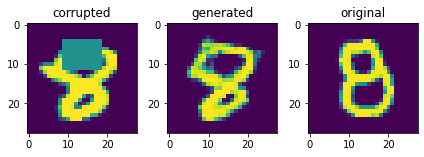

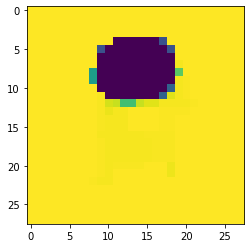

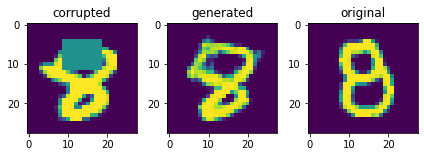

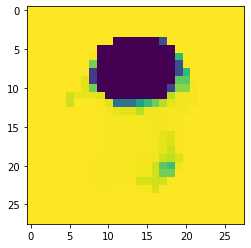

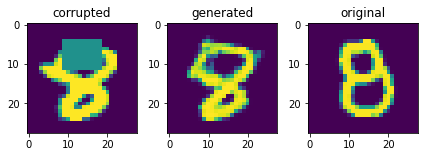

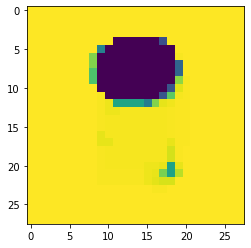

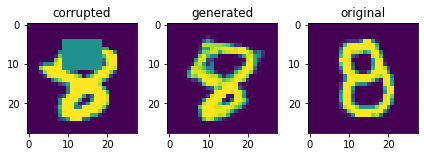

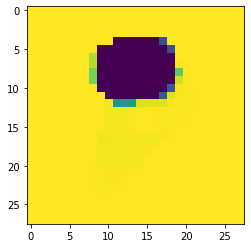

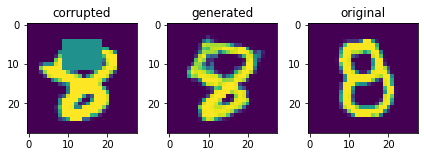

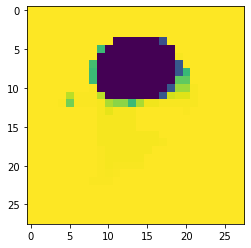

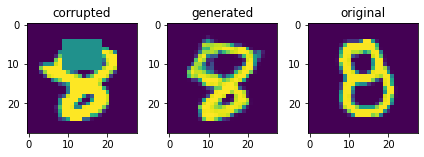

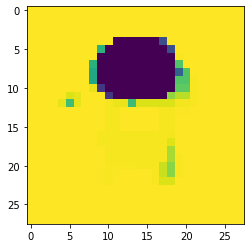

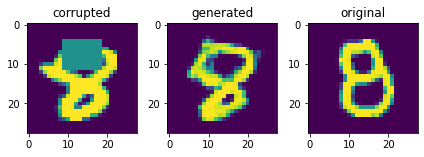

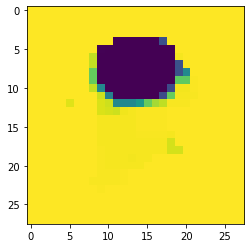

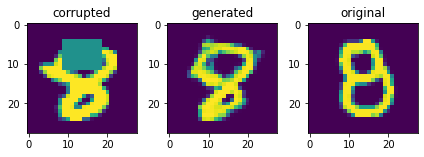

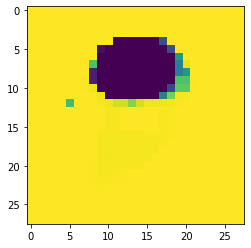

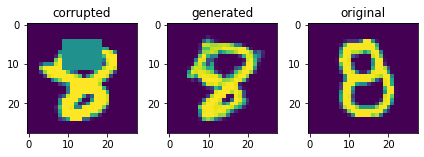

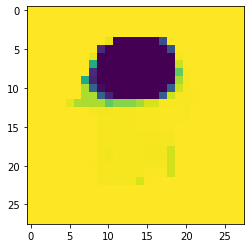

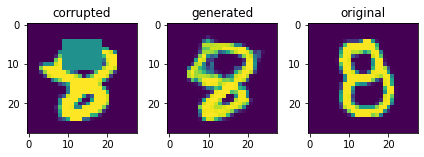

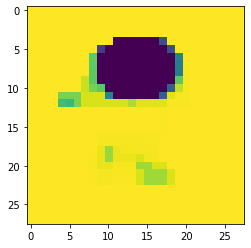

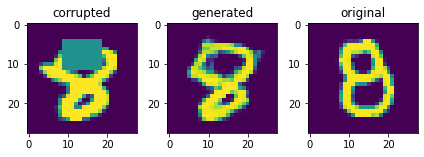

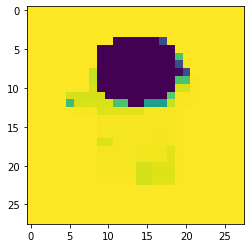

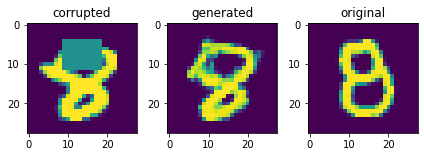

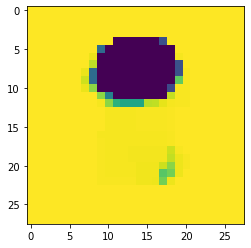

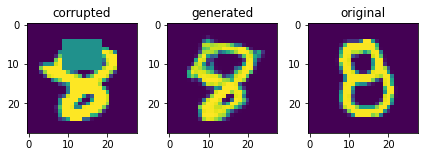

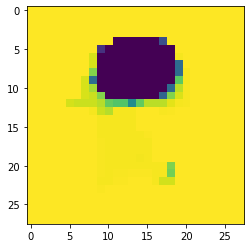

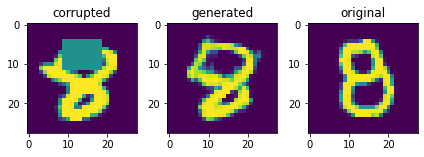

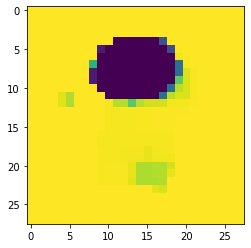

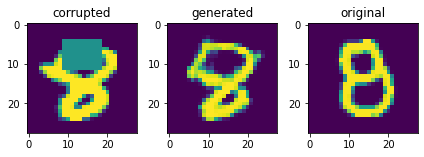

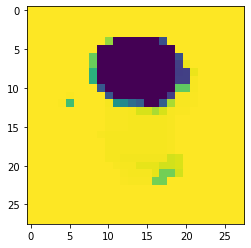

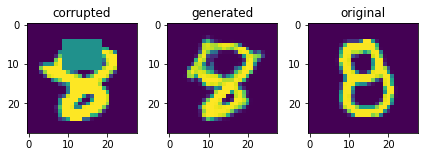

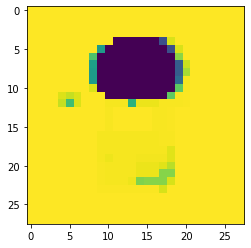

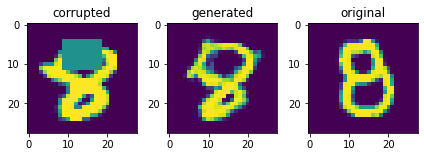

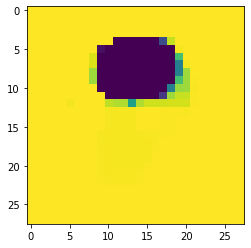

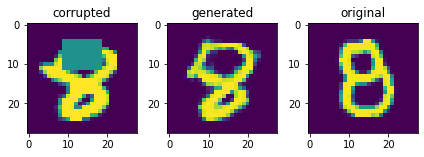

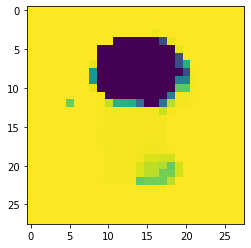

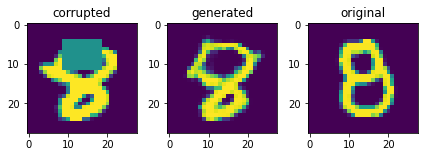

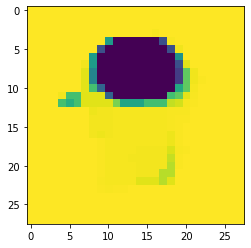

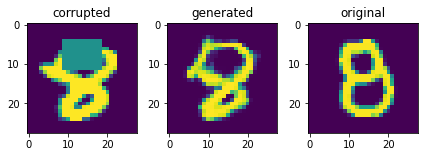

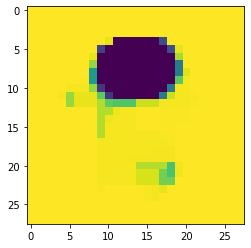

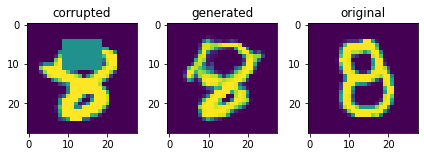

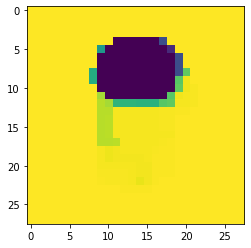

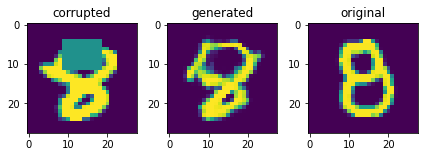

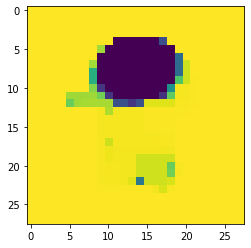

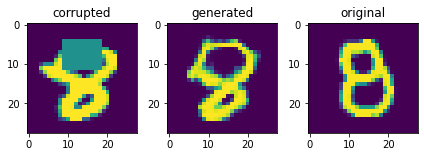

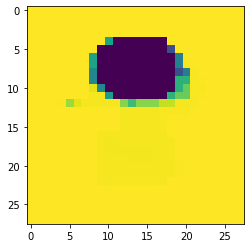

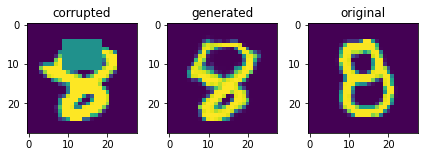

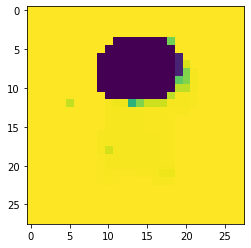

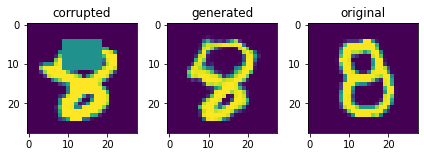

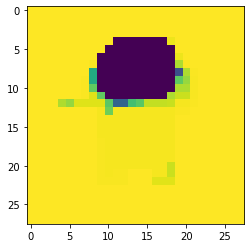

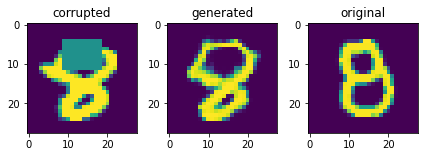

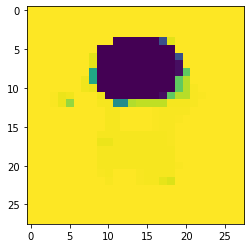

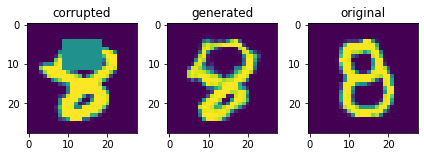

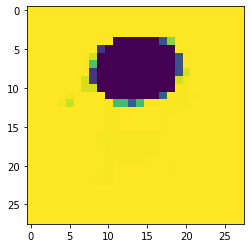

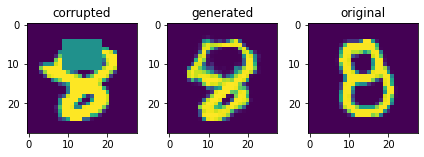

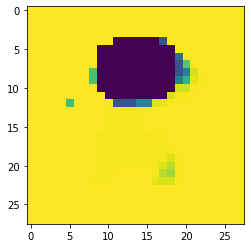

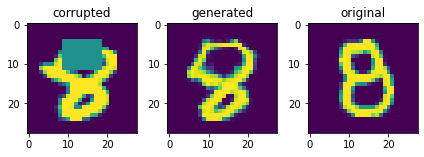

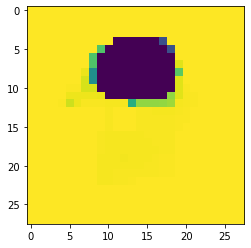

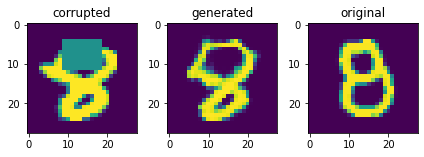

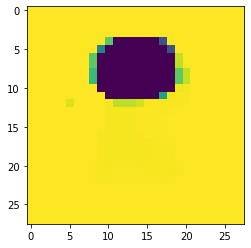

In [240]:
# Phase 2
# All in One
mask = back_mask(corrupted_images, generated_images, threshold=0.9)
mask_denoised = denoising(mask.detach().cpu().numpy()[0][0], kernel_size=3)
weighted_masks = get_weighted_mask(np.expand_dims(mask_denoised,0),window_size=5)

mask_optimum = nn.Parameter(torch.FloatTensor(np.expand_dims(mask_denoised,0)).cuda())
optimizer_mask = optim.Adam([mask_optimum], lr=1)

for epoch in range(1, 1000+1):

    # Z optimizer
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()



    # Mask optimizer
    optimizer_mask.zero_grad()
    generated_images = generator(z_optimum)
    c_loss = torch.sum(((mask_optimum * generated_images -corrupted_images)**2))
    c_loss.backward()
    optimizer_mask.step()


    # denoising
    mask_denoised = denoising(mask_optimum.detach().cpu().numpy()[0], kernel_size=3)
    weighted_masks = get_weighted_mask(np.expand_dims(mask_denoised,0),window_size=5)


    if epoch % 20 ==0:
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())

        plt.figure()
        plt.imshow(mask_denoised, vmin=0, vmax=1)
        plt.show()

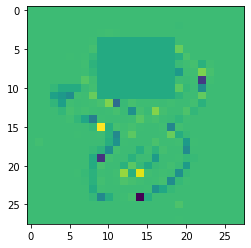

In [243]:
plt.imshow(mask_optimum.detach().cpu()[0])

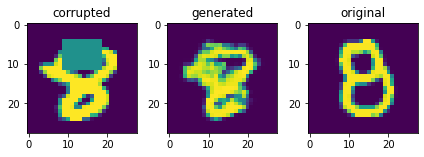

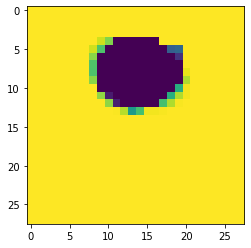

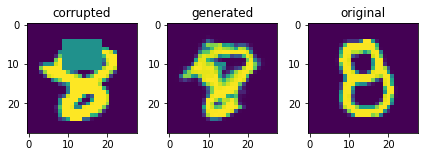

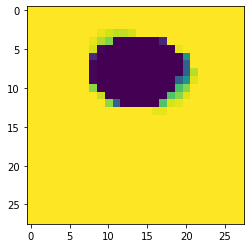

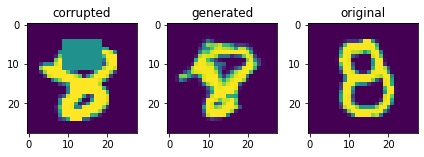

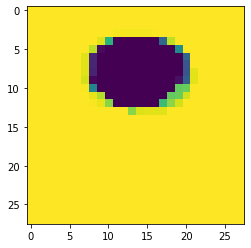

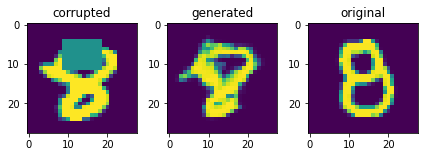

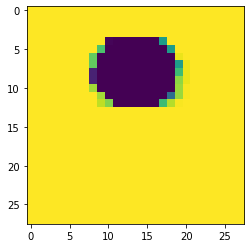

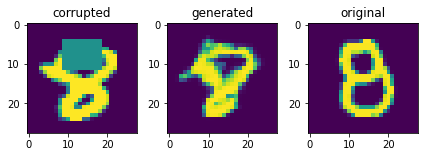

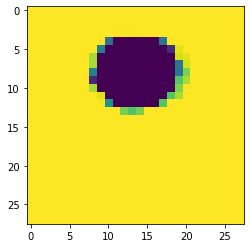

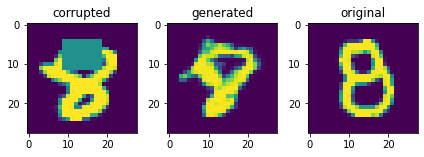

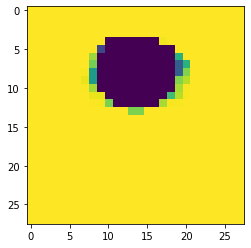

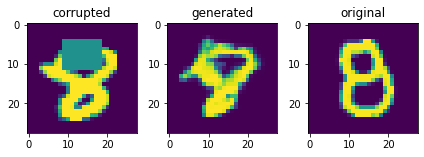

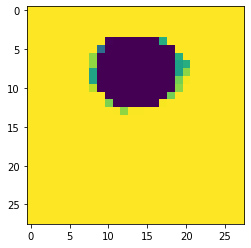

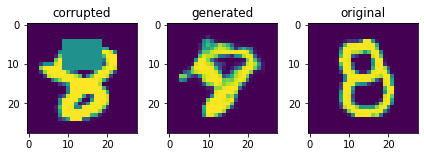

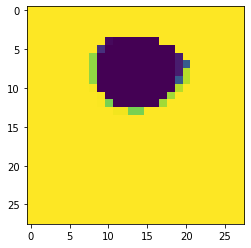

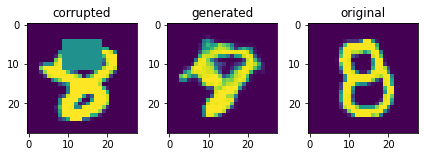

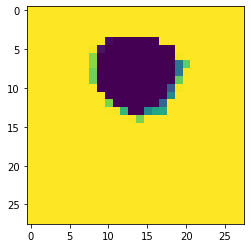

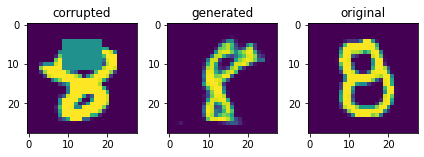

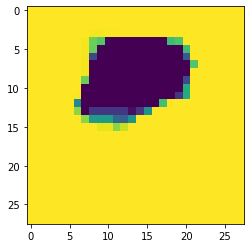

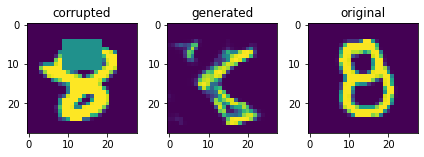

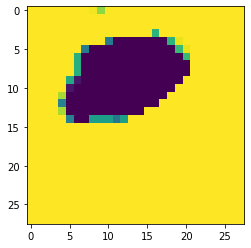

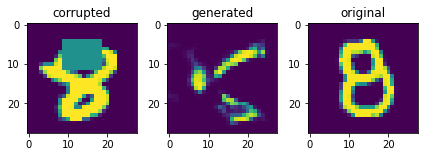

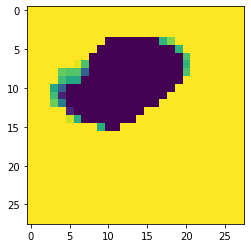

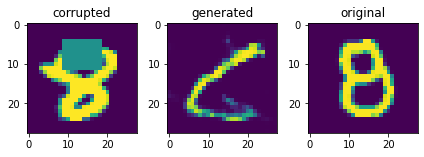

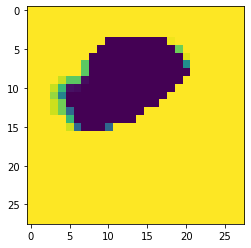

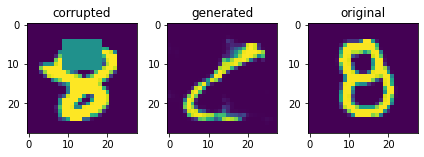

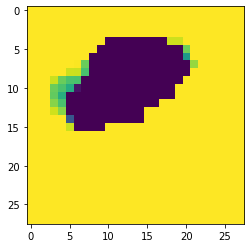

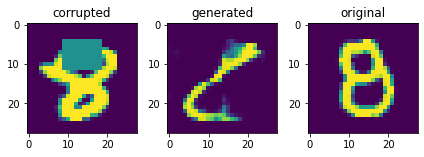

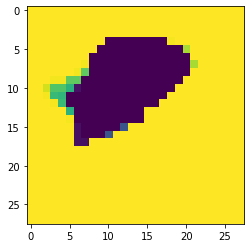

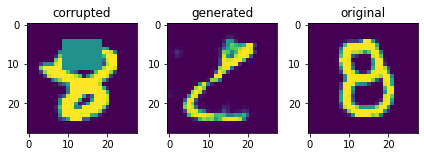

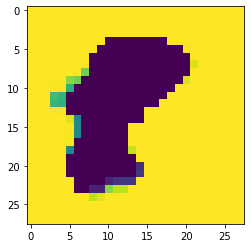

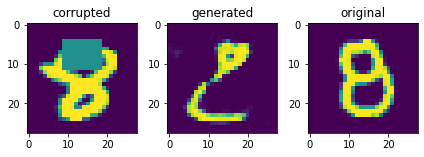

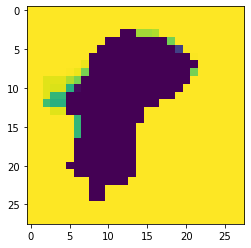

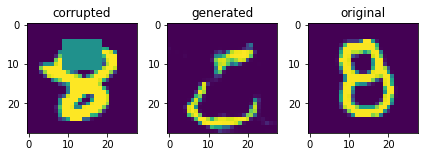

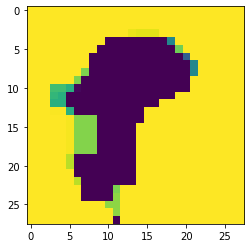

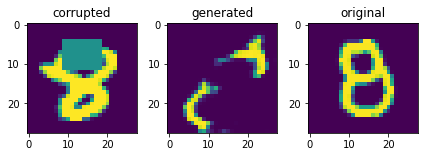

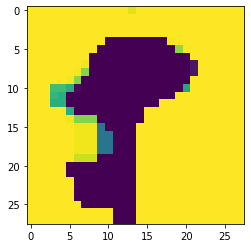

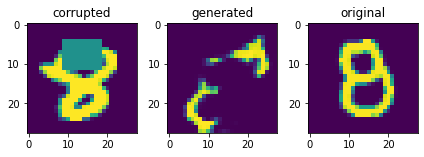

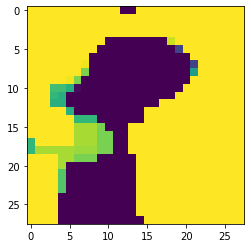

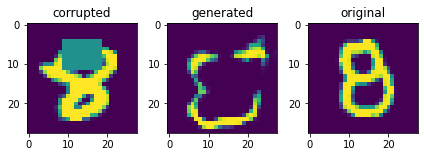

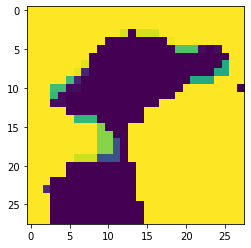

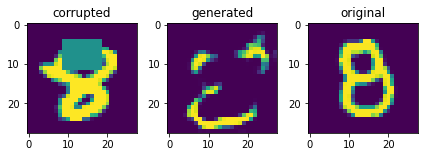

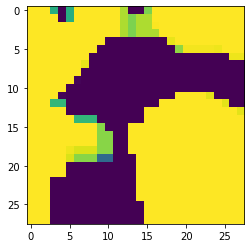

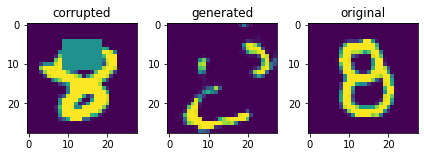

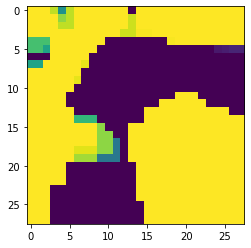

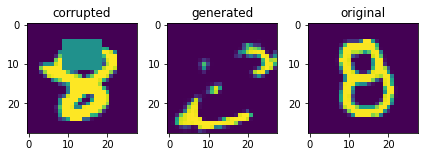

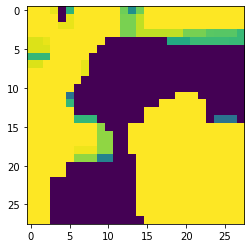

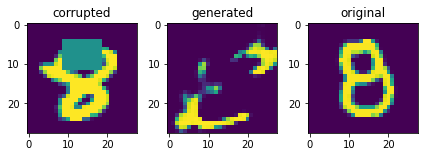

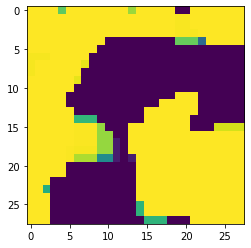

KeyboardInterrupt: 

In [233]:
# Phase 2
# All in One
mask = back_mask(corrupted_images, generated_images, threshold=0.9)
mask_denoised = denoising(mask.detach().cpu().numpy()[0][0], kernel_size=3)
weighted_masks = get_weighted_mask(np.expand_dims(mask_denoised,0),window_size=5)

mask_optimum = nn.Parameter(torch.FloatTensor(np.expand_dims(mask_denoised,0)).cuda())
optimizer_mask = optim.Adam([mask_optimum], lr=1)

for epoch in range(1, 1000+1):

    # Z optimizer
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()


    # Denoising
    weighted_masks = get_weighted_mask(
        np.expand_dims(mask_denoised,0),
        window_size=3)

    # Mask optimizer
    optimizer_mask.zero_grad()
    generated_images = generator(z_optimum)
    c_loss = context_loss(mask_optimum * generated_images , corrupted_images,
                          torch.tensor(weighted_masks).cuda())
    c_loss.backward()
    optimizer_mask.step()


    # denoising
    mask_denoised = denoising(mask_optimum.detach().cpu().numpy()[0], kernel_size=3)
    weighted_masks = get_weighted_mask(np.expand_dims(mask_denoised,0),window_size=5)


    if epoch % 20 ==0:
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())

        plt.figure()
        plt.imshow(mask_denoised, vmin=0, vmax=1)
        plt.show()

In [209]:
mask_denoised.shape

(28, 1)

In [64]:
mask_optimum[0][:5,10:15]

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
        [ 6.8079,  6.8742,  6.8870,  6.8607,  6.2364],
        [-4.8994,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
c_loss_s

In [ ]:
num_rnd = 0
ploter(corrupted_images[num_rnd,0].detach().cpu(),
               generated_images[num_rnd,0].detach().cpu(),
               original_images[num_rnd,0].detach().cpu())

In [ ]:
z_optimum = ???
optimizer_inpaint = optim.Adam([z_optimum], lr=0.1)

In [ ]:
corrupted_images = corrupted_images.cuda()
for epoch in range(500):
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = torch.sum(((corrupted_images-generated_images)**2))
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + 1*prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()

    mask = back_mask(corrupted_images, generated_images, threshold=0.9)
    weighted_masks = get_weighted_mask(mask[0].detach().cpu().numpy(),window_size=7)

"""
for epoch in range(100, optim_steps):
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss #+ prior_weight*prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()

    mask = back_mask(corrupted_images, generated_images, threshold=0.9)
    weighted_masks = get_weighted_mask(mask[0].detach().cpu().numpy(),window_size=7)

    if epoch % sample_interval ==0:
        # show a sample from generator
        num_rnd = math.floor(np.random.uniform(0, corrupted_images.shape[0]))
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
               generated_images[num_rnd,0].detach().cpu(),
               original_images[num_rnd,0].detach().cpu())
"""

In [ ]:
mask[0,0][10:15, 10:15]

In [ ]:
plt.imshow(mask.detach().cpu()[0][0], vmin=0, vmax=1)

In [ ]:
for epoch in range(500, optim_steps):
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss #+ prior_weight*prior_loss
    inpaint_loss.backward()
    optimizer_inpaint.step()

    #mask = back_mask(corrupted_images, generated_images, threshold=0.9)
    #weighted_masks = get_weighted_mask(mask[0].detach().cpu().numpy(),window_size=7)

    if epoch % sample_interval ==0:
        # show a sample from generator
        num_rnd = math.floor(np.random.uniform(0, corrupted_images.shape[0]))
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
               generated_images[num_rnd,0].detach().cpu(),
               original_images[num_rnd,0].detach().cpu())

In [ ]:
context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())

### Old

In [ ]:
for i, (corrupted_images, original_images, masks, weighted_masks) in enumerate(dataloader):
    corrupted_images, masks, weighted_masks = corrupted_images.cuda(), masks.cuda(), weighted_masks.cuda()

    print("Starting backprop to input ...")
    for epoch in range(optim_steps):

        optimizer_inpaint.zero_grad()

        generated_images = generator(z_optimum)
        discriminator_opinion = discriminator(generated_images)

        c_loss = context_loss(corrupted_images, generated_images, weighted_masks)

        prior_loss = torch.sum(-torch.log(discriminator_opinion))
        inpaint_loss = c_loss #+ prior_weight*prior_loss
        inpaint_loss.backward()
        optimizer_inpaint.step()
        print("[Epoch: {}/{}] \t[Loss: \t[Context: {:.3f}] \t[Prior: {:.3f}] \t[Inpaint: {:.3f}]]  \r".format(1+epoch, optim_steps, c_loss,
                                                                           prior_loss, inpaint_loss),end="")
        if epoch % sample_interval ==0:
            # show a sample from generator
            num_rnd = math.floor(np.random.uniform(0, corrupted_images.shape[0]))
            print(f"epoch : {epoch}")
            ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())
    #blended_images = posisson_blending(masks, generated_images.detach(), corrupted_images)

In [ ]:
def back_mask(corrupted_images, generated_images, threshold=0.9):
    mask_ = corrupted_images/generated_images
    mask = 1-mask_
    mask [mask<threshold] = 0
    #a = (corrupted_images - generated_images).abs()
    mask = 1-mask
    return mask

In [ ]:
mask = back_mask(corrupted_images, generated_images)
plt.imshow(mask[0][0].detach().cpu(), vmin=0, vmax=1)